In [1]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
import collections

In [20]:
import random

## Data

In [2]:
path = '../Data/cornell movie-dialogs corpus'

In [3]:
import re
delimiter = r'\+\+\+\$\+\+\+'

In [4]:
text = pd.read_csv(path+'/movie_lines.txt', sep = delimiter )

C:\Users\chao_gu\Anaconda3\envs\tensorflow_workshop\lib\site-packages\ipykernel\__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [5]:
text.columns = ['lineID','characterID','movieID','character name', 'utterance']

In [6]:
utterance = text['utterance']

In [7]:
utterance.shape

(304712,)

In [8]:
# encode data based on orrurance
def encode_data(data, vocabulary_size, space_before_sign = False):
    # data is a panda dataframe
    # merge data into a large piece
    if space_before_sign:
        words = data.apply(lambda x: re.sub('(?<=\w)([?,.!])',r' \1',str(x)))
    else:
        words = data.apply(lambda x: str(x))
    words = words.values.flatten()
    words_join = ' '.join(words)
    vocabulary = words_join.split()
    
    count = [['UNK', -1]] # mask unfrequent word with 'UNK'
    count.extend(collections.Counter(vocabulary).most_common(vocabulary_size - 1)) # minus 1 because we defined a unique UNK tag
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary) # tag the word with descending order    
    
    data_encode = list()
    unk_count = 0
    i = 0
    # encode data
    for sentence in words:
        new_sentence = sentence.split()
        code = list()
        for word in new_sentence:
            index = dictionary.get(word, 0) # set default value as 0
            # count UNK
            if index == 0:
                unk_count += 1
            code.append(index)
        data_encode.append(code)
    count[0][1] = unk_count
    return data_encode, count, dictionary

In [9]:
vocabulary_size = 50000

In [10]:
data, count, dictionary = encode_data(utterance, vocabulary_size, space_before_sign = True)

In [12]:
# reduce memory
del utterance 
del text

In [13]:
data_all = []
for i in data:
    data_all.extend(i)

In [14]:
# for this specific script, all sentences are merged into one long paragraph
data_all

[129,
 26,
 7,
 14,
 4,
 434,
 65,
 1,
 155,
 228,
 3,
 291,
 62,
 1,
 1166,
 199,
 29,
 72,
 130,
 136,
 7,
 767,
 120,
 7,
 740,
 1,
 48,
 19,
 791,
 1,
 17,
 21,
 120,
 798,
 5,
 43,
 842,
 24,
 43290,
 54,
 5,
 23,
 21,
 120,
 7,
 1012,
 3,
 354,
 31,
 1115,
 11,
 1110,
 30902,
 3,
 53,
 30903,
 21045,
 33,
 104,
 387,
 3,
 4,
 965,
 369,
 42,
 7,
 6,
 104,
 387,
 2952,
 1,
 344,
 226,
 14,
 123,
 4,
 103,
 7,
 262,
 57,
 131,
 439,
 38,
 30,
 24875,
 10,
 594,
 1,
 119,
 8289,
 43291,
 18364,
 1,
 19,
 37,
 2,
 2025,
 358,
 1,
 33,
 1265,
 3,
 26,
 5,
 468,
 7,
 24,
 1265,
 3,
 48,
 10,
 206,
 43292,
 360,
 2,
 6206,
 5,
 62,
 139,
 6932,
 2,
 72,
 130,
 149,
 37,
 87,
 1629,
 28,
 43293,
 281,
 17,
 202,
 83,
 24,
 4153,
 3,
 66,
 206,
 132,
 41,
 5,
 103,
 7,
 99,
 1,
 70,
 2,
 68,
 10,
 17,
 115,
 264,
 7,
 62,
 40,
 32,
 43294,
 2,
 82,
 5,
 3,
 4,
 25,
 3,
 4,
 739,
 20,
 5,
 93,
 55,
 6,
 608,
 2,
 58,
 5,
 202,
 1409,
 7,
 27,
 43295,
 30904,
 392,
 683,
 348,
 3,
 4,
 207,

In [22]:
reverse_dict = dict(zip(dictionary.values(),dictionary.keys()))

## Generate training batch 

In [75]:
data_index = 0
def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index # want to reuse global index in the iteration
#    assert batch_size % num_skips == 0
    assert num_skips <= 2* skip_window
    batch = np.ndarray (shape = (batch_size),dtype = np.int32)
    labels = np.ndarray (shape = (batch_size,1),dtype = np.int32)
    span = 2 * skip_window + 1 
    buffer = collections.deque(maxlen = span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
#     print('buffer before loop', buffer)
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data): # at the end of the paragraph, add the first span as right context, very ad hoc
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index]) # due to the fact that buffer is a deque, when append a new data will pop out the first one
            data_index += 1
#        print('batch',batch[i])
#        print('buffer after loop {}'.format(i),buffer)
#        print(data_index)
    # backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
#     print (data_index)
    return batch, labels

## Build and train 

In [54]:
batch_size = 128 # number of sample in each batch/iteration
embedding_size = 128 # dimension of embedding vector
skip_window = 1 # length of the context for each side
num_skips = 2 # number of input used to generate a label
num_sampled = 64 # number of negative example to sample

### validation set

In [55]:
valid_size = 16 # random set of words to evaluate similarity on
valid_window = 100 # only pick samples in the head of the distribution (high frequency)
valid_examples = np.random.choice(valid_window,valid_size,replace = False)

## Input

In [56]:
with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

In [57]:
with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [58]:
with tf.name_scope('weights'):
    nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],stddev = 1.0 / math.sqrt(embedding_size)))
with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

## loss

In [59]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights = nce_weights,
            biases = nce_biases,
            labels = train_labels,
            inputs = embed,
            num_sampled = num_sampled,
            num_classes = vocabulary_size
        )
    )

In [60]:
tf.summary.scalar('loss',loss)

<tf.Tensor 'loss_1:0' shape=() dtype=string>

In [62]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(loss)

In [63]:
# compute the cosine similarity between minibatch examples and all embeddings
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims = True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [64]:
similarity = tf. matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

In [65]:
merged = tf.summary.merge_all()

In [66]:
init = tf.global_variables_initializer()

In [67]:
num_steps = 100001

In [80]:
with tf.Session() as session:
    
    # open a writer to write summary
    writer = tf.summary.FileWriter('log',session.graph)
    #initialize variables
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(data_all,batch_size,num_skips,skip_window)
        feed_dict = {train_inputs:batch_inputs, train_labels:batch_labels}
        
        run_metadata = tf.RunMetadata()
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict = feed_dict,
            run_metadata = run_metadata
        )
        
        average_loss += loss_val
        
        writer.add_summary(summary,step)
        
        if step == (num_steps -1):
            writer.add_run_metadata(run_metadata,'step%d'%step)
        
        #average loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print ('Average loss at step',step,':',average_loss)
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dict[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log_str = 'Nearest to %s:'% valid_word
                for k in range(top_k):
                    close_word = reverse_dict[nearest[k]]
                    log_str = '%s %s,'%(log_str, close_word) # this is a nice way to extend string
                print(log_str)
    final_embeddings = normalized_embeddings.eval()
    writer.close()

Initialized
Average loss at step 0 : 268.9830322265625
Nearest to my: Noted, impotent, Gold, stormy, mallet, five-year, forgave, funky,
Nearest to we: Sleazebag, trivia, picketing, Wagnerian, ........, Contre-Espionnage, Amber's, "Stop,
Nearest to he: partner's, blocker, kneels, Olympics, kiddin',, Lance, War, shat,
Nearest to with: annoyed, ...of, Vichy, impossible;, life-blood, courtin', Bennett's, cocoa,
Nearest to was: Maranzano, typos, endangering, cravat, Cruikshank, station's, quad, Ma'am,
Nearest to .: Drunk, pounding, Spergazzi, forming, pansy, Smasheroo, deepest, Vig's,
Nearest to about: wouldn't've, assistant's, COME, intricate, Citizen, uses, Month, *sniffs*,
Nearest to and: minks, max-plus, will, against, capitalists, SHOOT, nobody's, shades,
Nearest to know: breaching, congregate, hypo, !...., throwing, separates, Answer, Domini,
Nearest to be: 'Horse, fuss, tasteless, this--you, fourteen, weakest, Beowulf, ...Newt,
Nearest to me: Sartorius, hunhh, Stern, featured, endowm

Average loss at step 62000 : 14.042108429074288
Average loss at step 64000 : 15.168629291296005
Average loss at step 66000 : 13.503298449158669
Average loss at step 68000 : 14.211014174342155
Average loss at step 70000 : 12.974184233427048
Nearest to my: your, the, a, and, ..., of, UNK, you,
Nearest to we: they, don't, somewhere, I, If, Well, it's, she,
Nearest to he: remember, just, any, how, Good, War, that's, you're,
Nearest to with: to, in, ..., for, !, ,, of, and,
Nearest to was: it's, get, I'm, is, day, leave, --, take,
Nearest to .: ?, !, ..., ,, the, --, a, and,
Nearest to about: know, At, different, happened, anything, gone, if, feel,
Nearest to and: ..., ,, in, the, is, of, your, a,
Nearest to know: want, But, told, Yeah, see, think, Mr, Yes,
Nearest to be: have, get, you're, think, !, run, him, take,
Nearest to me: it, him, you're, you, I'll, If, I, his,
Nearest to this: that, him, what, --, the, it, a, no,
Nearest to say: If, want, We, But, mean, feel, take, Yes,
Nearest to

In [93]:
final_embeddings.shape

(50000, 128)

In [95]:
valid_embeddings.shape

TensorShape([Dimension(16), Dimension(128)])

In [91]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'more labels than embedding'
    plt.figure(figsize=(72,72))
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label, 
                     xy=(x,y),
                    xytext = (5,2),
                     textcoords = 'offset points',
                     ha = 'right',
                     va = 'bottom')
    plt.savefig(filename)

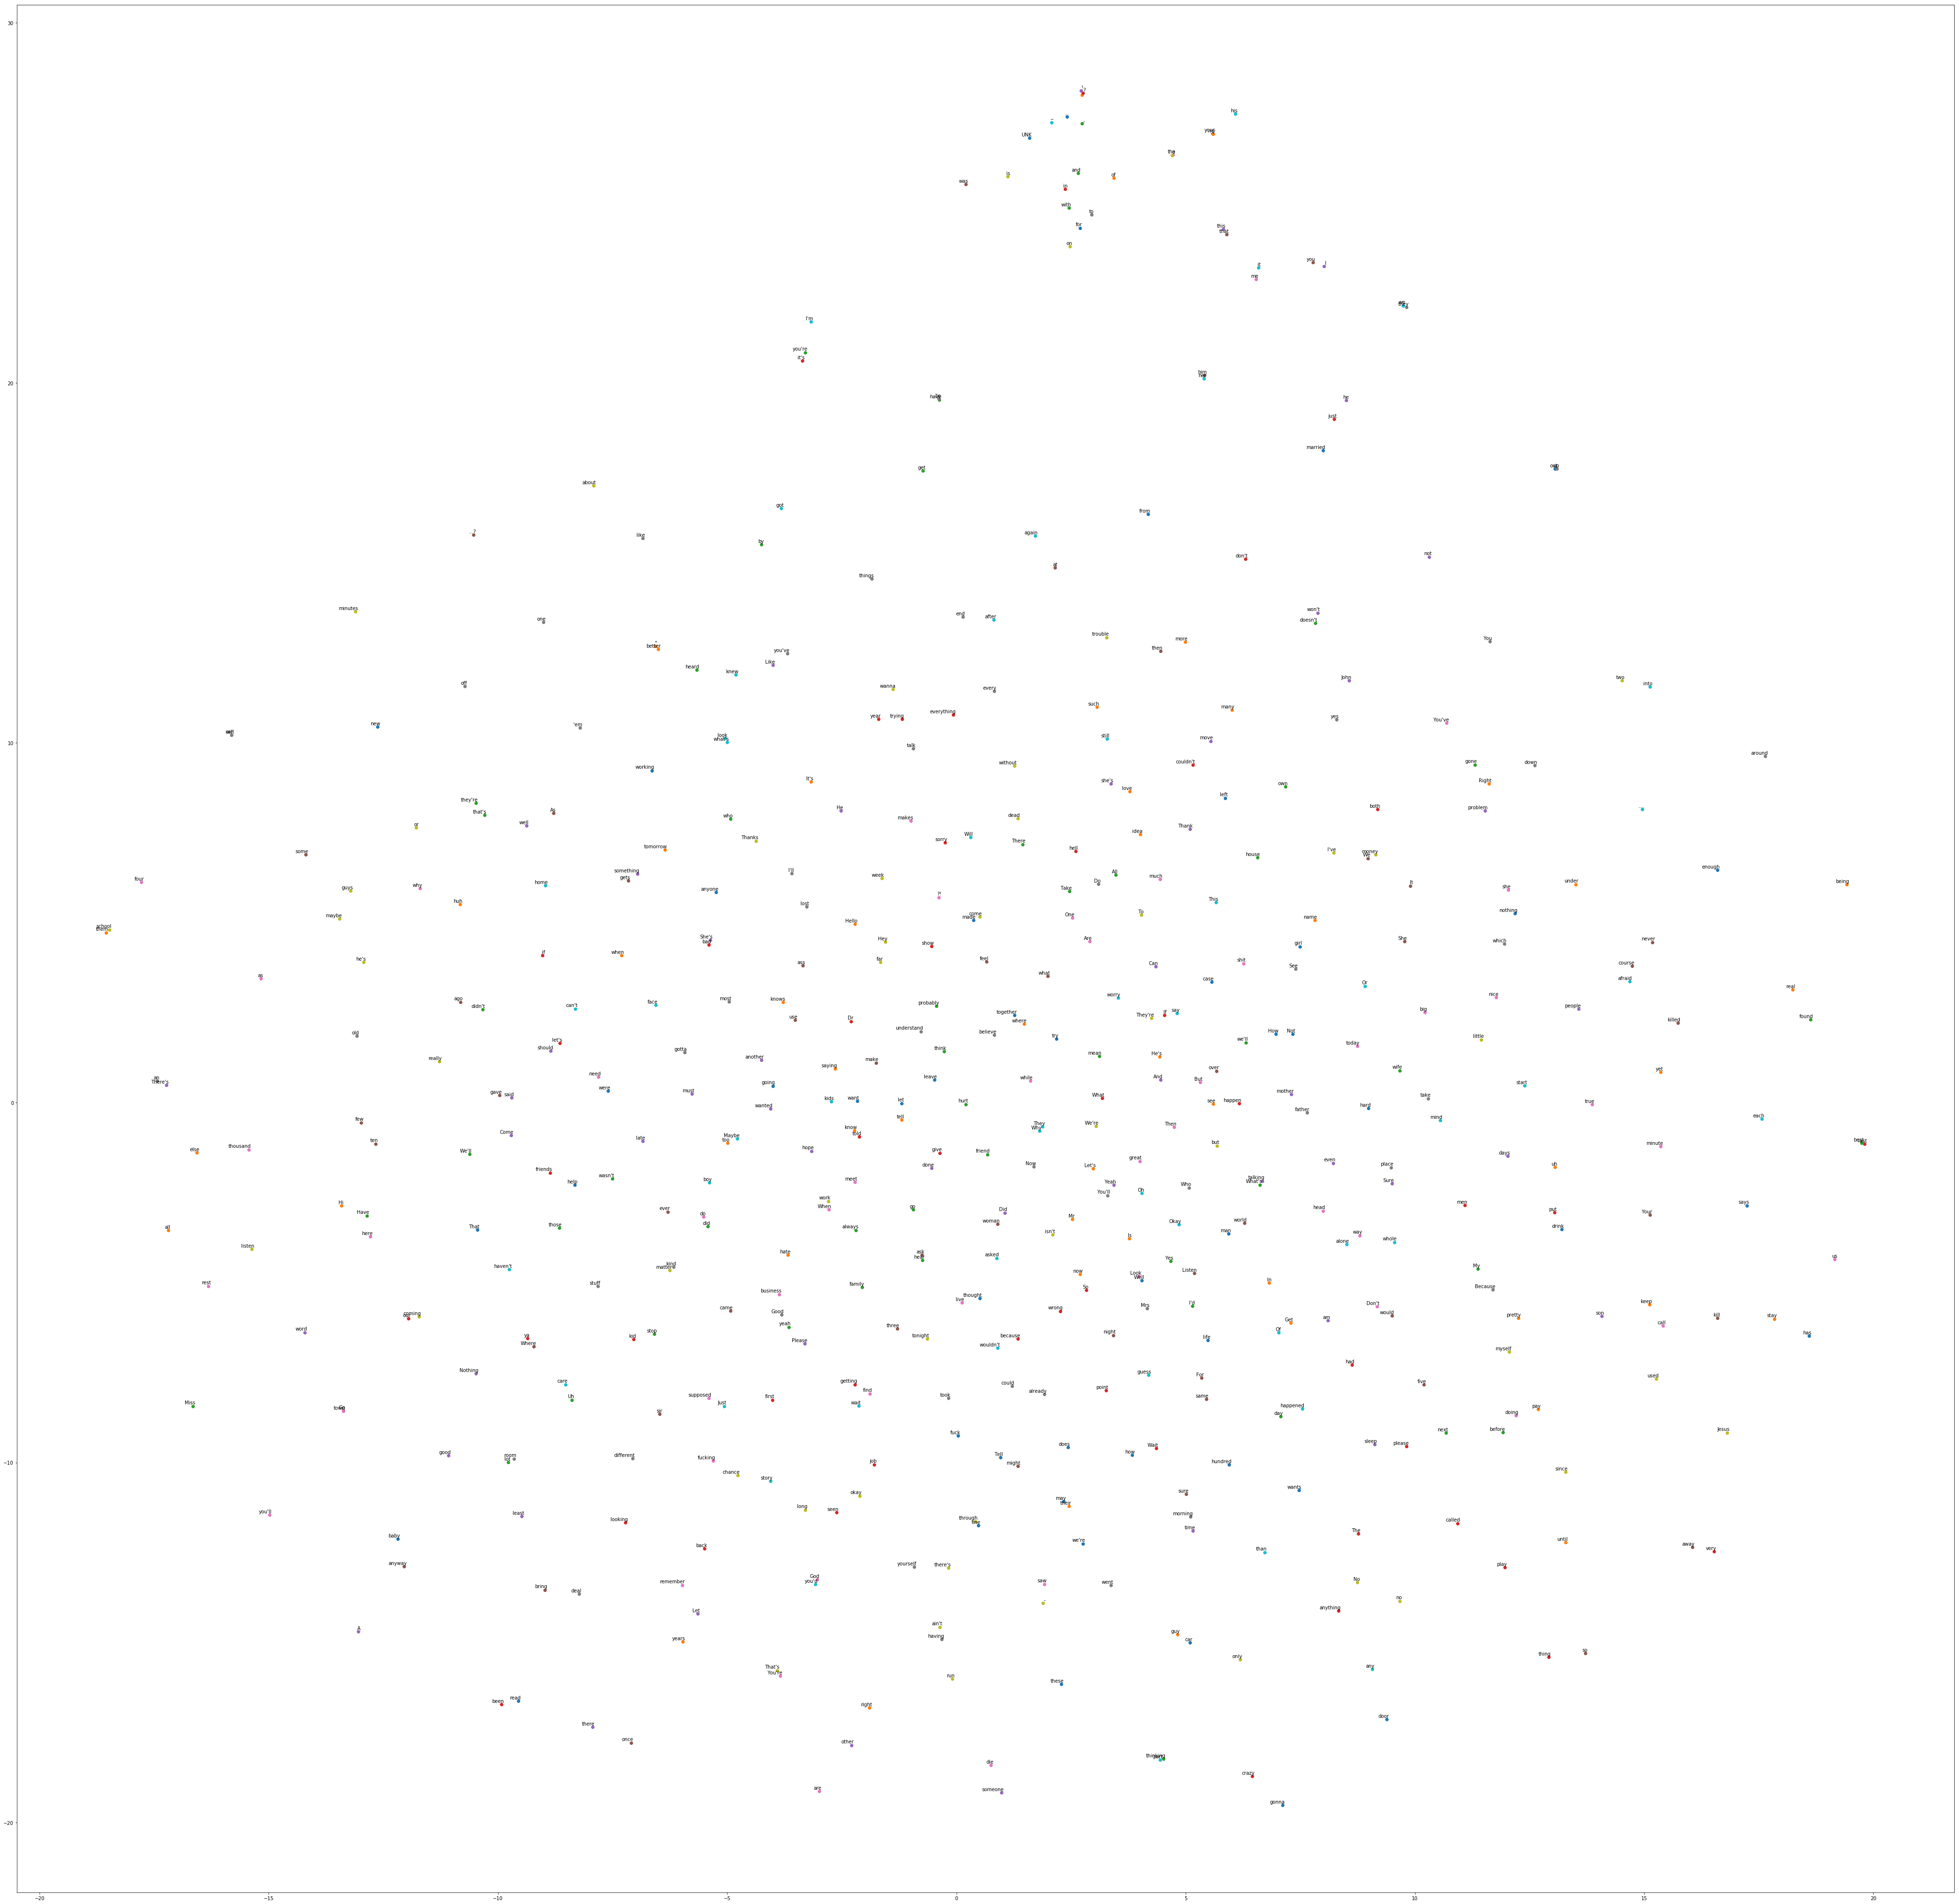

In [92]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(
        perplexity = 30,
        n_components = 2,
        init = 'pca',
        n_iter = 5000,
        method = 'exact'
    )
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dict[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs,labels,'tsne.png')
    
except ImportError as ex:
        print (ex)